### Import all necessary librsaries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
warnings.filterwarnings('ignore')

### Load dataset

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(train_data.shape)
print(test_data.shape)
# print(train_data.head)
# print(test_data.head)

(4209, 378)
(4209, 377)


### Q1. If for any column(s), the variance is equal to zero, then you need to remove those variable(s).

In [4]:
variance = pow(train_data.drop(columns={'ID','y'}).std(),2).to_dict()

null_cnt = 0
zero_variance_key = []
for key, value in variance.items():
    if(value==0):
        print('Name = ',key)
        zero_variance_key.append(key)
        null_cnt = null_cnt+1
print('No of columns which has zero variance = ',null_cnt)

## Remove zero variance data
zero_variance_key = set(zero_variance_key)
train_data = train_data.drop(columns=zero_variance_key)
train_data.shape

Name =  X11
Name =  X93
Name =  X107
Name =  X233
Name =  X235
Name =  X268
Name =  X289
Name =  X290
Name =  X293
Name =  X297
Name =  X330
Name =  X347
No of columns which has zero variance =  12


(4209, 366)

### Q2. Check for null and unique values for test and train sets.

In [5]:
if train_data.isnull().any().any():
    print("There are missing values in the train dataframe")
else:
    print("There are no missing values in the train dataframe")

if test_data.isnull().any().any():
    print("There are missing values in the test dataframe")
else:
    print("There are no missing values in the test dataframe")

There are no missing values in the train dataframe
There are no missing values in the test dataframe


### Q3. Apply label encoder.

In [6]:
le = LabelEncoder()
train_data_feature = train_data.drop(columns={'y','ID'})
train_data_target = train_data.y
print(train_data_feature.shape)
print(train_data_target.shape)
train_data_feature.describe(include='object')

train_data_feature['X0'] = le.fit_transform(train_data_feature.X0)
train_data_feature['X1'] = le.fit_transform(train_data_feature.X1)
train_data_feature['X2'] = le.fit_transform(train_data_feature.X2)
train_data_feature['X3'] = le.fit_transform(train_data_feature.X3)
train_data_feature['X4'] = le.fit_transform(train_data_feature.X4)
train_data_feature['X5'] = le.fit_transform(train_data_feature.X5)
train_data_feature['X6'] = le.fit_transform(train_data_feature.X6)
train_data_feature['X8'] = le.fit_transform(train_data_feature.X8)

(4209, 364)
(4209,)


### Q4. Perform dimensionality reduction.

In [7]:
pca = PCA(n_components=.95)
pca.fit(train_data_feature, train_data_target)

PCA(n_components=0.95)

In [8]:
train_data_feature_trans = pca.fit_transform(train_data_feature)
print(train_data_feature_trans.shape)

(4209, 6)


### Q5. Predict your test_df values using XGBoost.

In [9]:
train_x,test_x,train_y,test_y = train_test_split(train_data_feature_trans,train_data_target,test_size=.3,random_state=7)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2946, 6)
(2946,)
(1263, 6)
(1263,)


In [10]:
## Manually XGBoost's hyperparameters tuning

xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.4, max_depth = 10, alpha = 6, 
                           n_estimators = 20)
model = xgb_reg.fit(train_x,train_y)
print('RMSE = ',sqrt(mean_squared_error(model.predict(test_x),test_y)))

[14:37:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE =  12.172555373539563


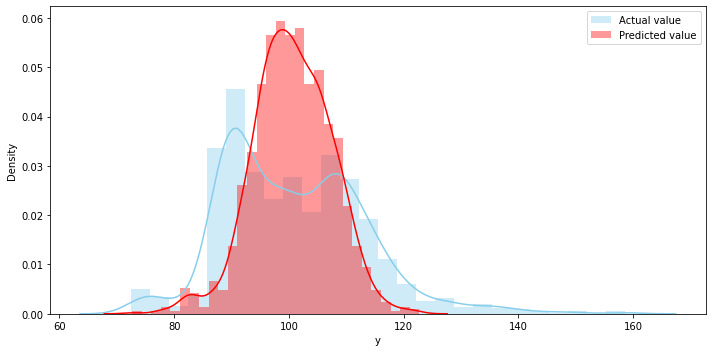

In [11]:
pred_test_y = model.predict(test_x)
plt.figure(figsize=(10,5))
sns.distplot(test_y[test_y<160], color="skyblue", label="Actual value")
sns.distplot(pred_test_y[pred_test_y<160] , color="red", label="Predicted value")
plt.legend()
plt.tight_layout()

In [12]:
##  k-fold Cross Validation using XGBoost

dmatrix_train = xgb.DMatrix(data=train_data_feature_trans,label=train_data_target)
params = {'objective':'reg:linear', 'colsample_bytree': 0.3, 'learning_rate': 0.3, 'max_depth': 5, 'alpha': 10}
model_cv = xgb.cv(dtrain=dmatrix_train, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, 
                      metrics="rmse", as_pandas=True, seed=7)
model_cv.tail(4)

[14:37:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:37:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[14:37:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
25,9.510865,0.190362,11.257347,0.669333
26,9.381275,0.223279,11.205358,0.674828
27,9.291824,0.239120,11.191368,0.663827
28,9.233109,0.200560,11.163756,0.682884


In [13]:
## Prediction on test data set using XGBoost
#  Preparing test data set.

test_data = test_data.drop(columns=zero_variance_key)
test_data.shape

(4209, 365)

In [14]:
test_data.isnull().sum().any()

False

In [15]:
test_data_feature = test_data.drop(columns={'ID'})
test_data_feature.describe(include='object')
test_data_feature['X0'] = le.fit_transform(test_data_feature.X0)
test_data_feature['X1'] = le.fit_transform(test_data_feature.X1)
test_data_feature['X2'] = le.fit_transform(test_data_feature.X2)
test_data_feature['X3'] = le.fit_transform(test_data_feature.X3)
test_data_feature['X4'] = le.fit_transform(test_data_feature.X4)
test_data_feature['X5'] = le.fit_transform(test_data_feature.X5)
test_data_feature['X6'] = le.fit_transform(test_data_feature.X6)
test_data_feature['X8'] = le.fit_transform(test_data_feature.X8)

In [16]:
pca.fit(test_data_feature)

PCA(n_components=0.95)

In [17]:
test_data_feature_trans = pca.fit_transform(test_data_feature)
print(test_data_feature_trans.shape)

(4209, 6)


In [18]:
test_pred = model.predict(test_data_feature_trans)
test_pred

array([ 89.51911 ,  96.5094  , 106.30283 , ...,  96.489136, 108.05312 ,
       100.4434  ], dtype=float32)

        ID       y  X0 X1  X2 X3 X4  X5 X6 X8  ...  X375  X376  X377  X378  \
0        0  130.81   k  v  at  a  d   u  j  o  ...     0     0     1     0   
1        6   88.53   k  t  av  e  d   y  l  o  ...     1     0     0     0   
2        7   76.26  az  w   n  c  d   x  j  x  ...     0     0     0     0   
3        9   80.62  az  t   n  f  d   x  l  e  ...     0     0     0     0   
4       13   78.02  az  v   n  f  d   h  d  n  ...     0     0     0     0   
...    ...     ...  .. ..  .. .. ..  .. .. ..  ...   ...   ...   ...   ...   
4204  8405  107.39  ak  s  as  c  d  aa  d  q  ...     1     0     0     0   
4205  8406  108.77   j  o   t  d  d  aa  h  h  ...     0     1     0     0   
4206  8412  109.22  ak  v   r  a  d  aa  g  e  ...     0     0     1     0   
4207  8415   87.48  al  r   e  f  d  aa  l  u  ...     0     0     0     0   
4208  8417  110.85   z  r  ae  c  d  aa  g  w  ...     1     0     0     0   

      X379  X380  X382  X383  X384  X385  
0        0     0    

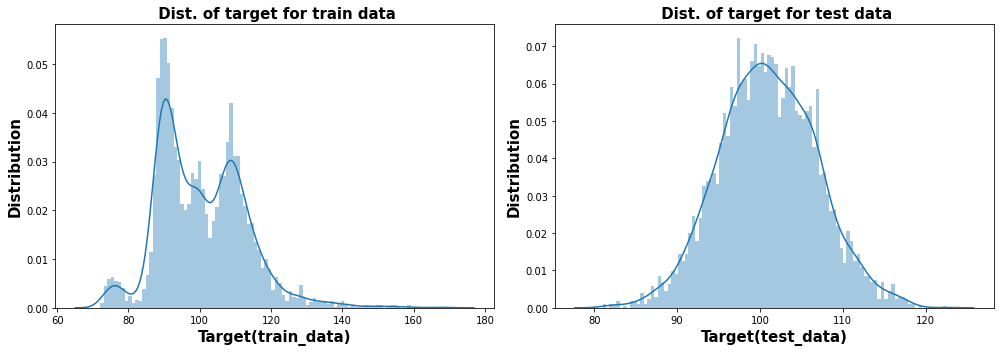

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

train_plot = sns.distplot(train_data_target[train_data_target<200], bins=100, kde=True, ax=ax[0])
train_plot.set_xlabel('Target(train_data)', weight='bold', size=15)
train_plot.set_ylabel('Distribution', weight='bold', size=15)
train_plot.set_title(' Dist. of target for train data', weight='bold', size=15)
 
test_plot = sns.distplot(test_pred[test_pred<200], bins=100, kde=True, ax=ax[1])
test_plot.set_xlabel('Target(test_data)', weight='bold', size=15)
test_plot.set_ylabel('Distribution', weight='bold', size=15)
test_plot.set_title(' Dist. of target for test data', weight='bold', size=15)

plt.tight_layout()